In [1]:
import pandas as pd
# Plow that show the distribution of the number of items per session
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_ecommerce= pd.read_json('1_ecommerce.jsonl', lines=True)
df_ecommerce.head(5)

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [3]:
# for each session, we will create a list of items that the user has clicked on, removing duplicates
events_list = []
for i in df_ecommerce.events:
    clicks = []
    for j in i:
        if j['type'] == 'clicks':
            clicks.append(j['aid'])

    events_list.append(list(clicks))

In [4]:
df_ecommerce['items'] = events_list
df = df_ecommerce.drop(columns=["events"], axis=1)

In [5]:
df.head()

,session,items
0,12899779,[59625]
1,12899780,"[1142000, 582732, 973453, 736515, 1142000]"
2,12899781,"[141736, 199008, 57315, 194067, 199008, 199008..."
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
4,12899783,"[255297, 1114789, 255297, 300127, 198385, 3001..."


In [6]:
# takes only the session with items length higher than 20
df_truncated = df[df['items'].apply(lambda x: len(x) > 20)]
df_truncated


,session,items
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
6,12899785,"[1784451, 1169631, 95259, 970225, 95259, 60821..."
30,12899809,"[963478, 385521, 963478, 385521, 385521, 21305..."
36,12899815,"[1519178, 772784, 307161, 307161, 101371, 7115..."
44,12899823,"[409620, 409620, 409620, 215561, 1336044, 1586..."
...,...,...
1669955,14569734,"[1702457, 1751849, 409620, 730130, 372942, 228..."
1670113,14569892,"[1554565, 335380, 1594229, 1123586, 1121373, 1..."
1670184,14569963,"[1059846, 746134, 746134, 1059846, 81016, 1059..."
1670676,14570455,"[1311630, 1532732, 727429, 1216419, 1015403, 1..."


In [7]:
df= df_truncated.copy()
# redefine index    
df.reset_index(drop=True, inplace=True)
df

,session,items
0,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
1,12899785,"[1784451, 1169631, 95259, 970225, 95259, 60821..."
2,12899809,"[963478, 385521, 963478, 385521, 385521, 21305..."
3,12899815,"[1519178, 772784, 307161, 307161, 101371, 7115..."
4,12899823,"[409620, 409620, 409620, 215561, 1336044, 1586..."
...,...,...
39943,14569734,"[1702457, 1751849, 409620, 730130, 372942, 228..."
39944,14569892,"[1554565, 335380, 1594229, 1123586, 1121373, 1..."
39945,14569963,"[1059846, 746134, 746134, 1059846, 81016, 1059..."
39946,14570455,"[1311630, 1532732, 727429, 1216419, 1015403, 1..."


In [8]:
# Explode the 'items' column to create one row per item per session
df_exploded_items = df.explode('items')

In [9]:
df_exploded_items

,session,items
0,12899782,1669402
0,12899782,1494780
0,12899782,1494780
0,12899782,1494780
0,12899782,1674681
...,...,...
39947,14570515,473057
39947,14570515,1784517
39947,14570515,1521766
39947,14570515,1784517


In [10]:
# count how many times each item appears in the dataset
item_counts = df_exploded_items['items'].value_counts()
item_counts

items
108125     1349
1460571    1166
485256      650
986164      597
659399      568
           ... 
1122304       1
684628        1
108476        1
1620032       1
71330         1
Name: count, Length: 364522, dtype: int64

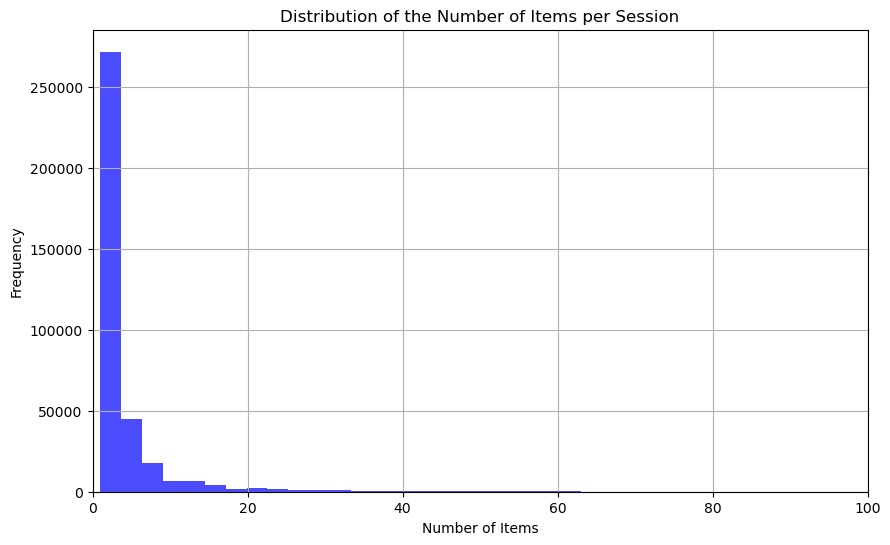

In [11]:
# create a plot of the distribution of the number of each item in the dataset
plt.figure(figsize=(10, 6))
plt.hist(item_counts, bins=500, color='blue', alpha=0.7)
plt.title('Distribution of the Number of Items per Session')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
# set x-axis limits to 0-100
plt.xlim(0, 100)
plt.grid(True)
plt.show()

In [12]:
# remove all the items that appear less than 10 times in the dataset
item_counts = item_counts[item_counts > 10]

# re,pve each row in the dataset that contains an item that appears less than 10 times in the dataset
df_exploded_items = df_exploded_items[df_exploded_items['items'].isin(item_counts.index)]

In [13]:
# Count the occurrences of each item in each session and drop duplicates
df_exploded_items['item_count'] = df_exploded_items.groupby(['session', 'items'])['items'].transform('count')
df_exploded_items = df_exploded_items.drop_duplicates(subset=['session', 'items'])



C:\Users\adria\AppData\Local\Temp\ipykernel_29080\3118152184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploded_items['item_count'] = df_exploded_items.groupby(['session', 'items'])['items'].transform('count')


In [14]:
# cerca un valore che ha item_count > 1
df_exploded_items[df_exploded_items['item_count'] > 1].sort_values(by='item_count', ascending=False).head(10)


,session,items,item_count
11950,13327355,1760714,99
12505,13350026,71903,76
9671,13235383,1825743,60
10269,13259261,435003,54
35705,14340719,1448678,54
15604,13476229,63971,50
11758,13319241,277064,49
7997,13179578,1215540,48
35802,14343844,764607,48
25893,13908293,1330503,47


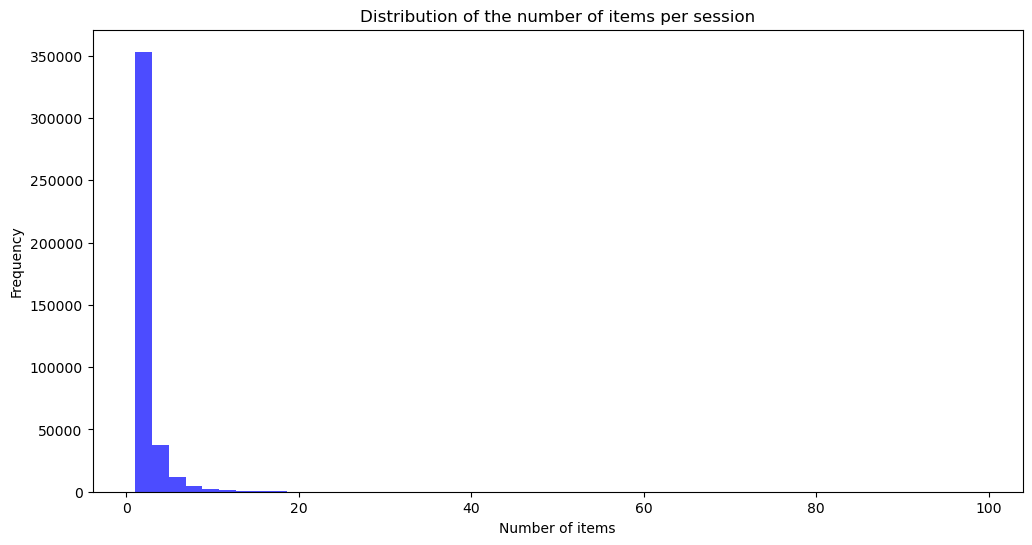

In [15]:
plt.figure(figsize=(12, 6))
# Set the title of the plot
plt.title('Distribution of the number of items per session')
# Set the x and y labels
plt.xlabel('Number of items')
plt.ylabel('Frequency')
# Create the histogram
plt.hist(df_exploded_items['item_count'], bins=50, color='blue', alpha=0.7)
# Show the plot
plt.show()

In [16]:
# work only with the first 1000 sessions of the dataset
#df_exploded_items = df_exploded_items.head(100_000)
#df_exploded_items = df_exploded_items.reset_index(drop=True)
df_exploded_items

,session,items,item_count
0,12899782,45034,1
0,12899782,603159,1
0,12899782,476063,3
0,12899782,562753,2
0,12899782,975116,2
...,...,...,...
39946,14570455,932386,1
39946,14570455,1274743,1
39947,14570515,1521766,4
39947,14570515,473057,7


In [17]:
# transform the itemCount in a float number
#df_exploded_items['item_count'] = df_exploded_items['item_count'].astype(float)

In [18]:
# use the index of the dataframe as session id
#df_exploded_items['session'] = df_exploded_items.index
df_exploded_items['items'] = df_exploded_items['items'].astype('category')
df_exploded_items


,session,items,item_count
0,12899782,45034,1
0,12899782,603159,1
0,12899782,476063,3
0,12899782,562753,2
0,12899782,975116,2
...,...,...,...
39946,14570455,932386,1
39946,14570455,1274743,1
39947,14570515,1521766,4
39947,14570515,473057,7


In [19]:
df_pivot = df_exploded_items.pivot_table(index='session', columns='items', values='item_count', aggfunc='first')
df_pivot

C:\Users\adria\AppData\Local\Temp\ipykernel_29080\48260202.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_exploded_items.pivot_table(index='session', columns='items', values='item_count', aggfunc='first')


items,3,53,137,219,447,605,647,681,691,778,...,1854691,1854775,1854872,1855113,1855333,1855464,1855485,1855500,1855525,1855591
session,,,,,,,,,,,,,,,,,,,,,
12899782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12899785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12899809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12899815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12899823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14569734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14569892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14569963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd

# Supponiamo che df_pivot sia già stato creato come segue:
# df_pivot = df_exploded_items.pivot_table(index='session', columns='items', values='item_count', aggfunc='sum')
# Per questa implementazione, consideriamo il campo item_count come rating

# Convertiamo il DataFrame in una matrice numpy, mantenendo i NaN per le celle mancanti
R_df = df_pivot.copy()
# Creiamo una maschera: 1 per gli elementi osservati, 0 altrimenti
mask = (~R_df.isna()).astype(float).values

# Sostituiamo i NaN in R con 0 (non verranno usati nel calcolo dell'errore grazie alla maschera)
R = R_df.fillna(0).values

def unconstrained_matrix_factorization(R, mask, k=10, epochs=100, alpha=0.001, tolerance=1e-5, seed=42):
    """
    R: matrice dei rating (numpy array) ottenuta dal pivot, con 0 per le celle mancanti
    mask: matrice con 1 per gli elementi osservati e 0 per i mancanti
    k: numero di fattori latenti
    epochs: numero di iterazioni
    alpha: learning rate
    """
    num_users, num_items = R.shape
    # Inizializzazione casuale delle matrici dei fattori
    
    np.random.seed(seed)  # per la riproducibilità
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    
    losses = []  # per tenere traccia della funzione di costo

    prev_cost = None
    for epoch in range(epochs):
        # Calcolo delle predizioni
        R_hat = U.dot(V.T)
        # Calcolo dell'errore solo sugli elementi osservati
        error = (R - R_hat) * mask
        # Calcolo della funzione di costo (loss)
        cost = np.sum(error**2) / 2
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, costo: {cost:.4f}")
        # Aggiornamento dei fattori tramite gradient descent

        # Calcolo del gradiente
        U_grad = error.dot(V)
        V_grad = error.T.dot(U)
        
        U += alpha * U_grad
        V += alpha * V_grad

        losses.append(cost)

        # Early stopping se il costo non cambia significativamente
        if prev_cost is not None and abs(prev_cost - cost) < tolerance:
            print(f"Early stopping at epoch {epoch}")
            return U, V, losses
    
    return U, V, losses

# Eseguiamo la fattorizzazione
k = 10         # ad esempio, 10 fattori latenti
epochs = 100   # numero di iterazioni
alpha = 0.001  # learning rate

U, V, losses = unconstrained_matrix_factorization(R, mask, k=k, epochs=epochs, alpha=alpha)

# Una volta appresi U e V, la matrice dei rating completa è data da:
R_complete = U.dot(V.T) 

# Ad esempio, per predire il rating (item_count) della sessione 0 sull'item con indice 5:
predicted_rating = R_complete[0, 5]
print(f"Predicted rating per sessione 0, item 5: {predicted_rating:.4f}")


Epoch 0, costo: 915594.4496
Epoch 1, costo: 847262.7014
Epoch 2, costo: 801537.2538
Epoch 3, costo: 766954.1331
Epoch 4, costo: 739219.3547
Epoch 5, costo: 716110.9575
Epoch 6, costo: 696308.3700
Epoch 7, costo: 678964.5503
Epoch 8, costo: 663505.9475
Epoch 9, costo: 649528.2828
Epoch 10, costo: 636737.4064
Epoch 11, costo: 624913.8453
Epoch 12, costo: 613890.5487
Epoch 13, costo: 603538.3529
Epoch 14, costo: 593756.1879
Epoch 15, costo: 584464.2812
Epoch 16, costo: 575599.3146
Epoch 17, costo: 567110.8678
Epoch 18, costo: 558958.7224
Epoch 19, costo: 551110.7412
Epoch 20, costo: 543541.1421
Epoch 21, costo: 536229.0515
Epoch 22, costo: 529157.2764
Epoch 23, costo: 522311.2704
Epoch 24, costo: 515678.2877
Epoch 25, costo: 509246.7314
Epoch 26, costo: 503005.6941
Epoch 27, costo: 496944.6800
Epoch 28, costo: 491053.4821
Epoch 29, costo: 485322.1755
Epoch 30, costo: 479741.1846
Epoch 31, costo: 474301.3825
Epoch 32, costo: 468994.1913
Epoch 33, costo: 463811.6614
Epoch 34, costo: 458746.

In [ ]:
# save the matrix R_complete in a pickle file
import pickle
with open('R_complete.pkl', 'wb') as f:
    pickle.dump(R_complete, f)
# save the matrix R in a pickle file
with open('R.pkl', 'wb') as f:
    pickle.dump(R, f)

In [ ]:
# plot the loss function
plt.plot(losses)
plt.title('Loss function during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
U_2, V_2, losses_2 = unconstrained_matrix_factorization(R, mask, k=20, epochs=epochs, alpha=0.01)

In [ ]:
with open('R_complete_2.pkl', 'wb') as f:
    pickle.dump(R_complete, f)
with open('R_2.pkl', 'wb') as f:
    pickle.dump(R, f)

In [ ]:
# plot the loss function
plt.plot(losses_2)
plt.title('Loss function during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()